# Siamese Neural Network Training For Facial Recognition
## This notebook demonstrates the complete process of training a Siamese Neural Network for face verification. The model is designed to recognize my own face by learning facial similarity metrics through paired comparisons.

### The notebook covers:

Data Loading and Preparation

Preprocessing Pipeline

Siamese Architecture

Training

Model Evaluation

## Import Necessary Libraries

In [6]:
import tensorflow as tf
import keras

In [7]:
# import standard dependencies
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [ ]:
# import functional API and necessary layer types
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten, BatchNormalization, Dropout
"""
layer allows to create a custom NN layer
conf2d - performs convolutions on images
dense - fully connected layer
maxpooling - shrink/averages the information together
input - allows us to define what we're passing through to our model
flatten - takes all info and flattens it down into a single dimension. going from convoltional data to a dense  layer
batchnormalizaiton - mitigates effects of suboptimal weight initializations by noramlizing outputs of convolutional layers
                     to keep ouput distributions consistent across batches of data
dropout - prevents overfitting, allowing to learn generalizable features by setting random neurons to 0 during training
"""


In [9]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)


In [10]:
print("GPU Available: ", tf.config.list_physical_devices('GPU'))
print("GPU is being used:", tf.test.is_gpu_available())  # Returns True if GPU is being used

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


GPU Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU is being used: True


In [11]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Extract images and Create Dataset

In [12]:
# set up folder structure
# three data folders: anchor, positive, negative
# anchor will be the input image, then we will check if the anchor matches the positive image or a negative image
# Update paths to point to Google Drive
POS_PATH = '/content/drive/MyDrive/facial_recognition/data/positives'
NEG_PATH = '/content/drive/MyDrive/facial_recognition/data/negatives'
ANC_PATH = '/content/drive/MyDrive/facial_recognition/data/anchors'

In [13]:
# get images from directories
anchor = tf.data.Dataset.list_files(ANC_PATH+'/*.jpg').take(4356)
positive = tf.data.Dataset.list_files(POS_PATH+'/*.jpg').take(4356)
negative = tf.data.Dataset.list_files(NEG_PATH+'/*.jpg').take(4356)

In [14]:
# preprocessing: Load image from directory, resize and scale
def preprocess(file_path):
    # read img from file path
    byte_img = tf.io.read_file(file_path)
    # load in img
    img = tf.io.decode_jpeg(byte_img)

    # preprocessing - resizing the img to be 100x100x3
    img = tf.image.resize(img, (100,100))
    # scale image to be between 0 and 1
    img = img / 255.0
    return img

### Create Labelled dataset


In [15]:
# create positive samples - (anchor, positive,1)
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
# create negative samples - (anchor, negative, 0)
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
# compleat labelled dataset by concatenating negative samples to positive samples
data = positives.concatenate(negatives)

In [16]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

### Build dataloader pipeline

In [17]:
data = data.map(preprocess_twin)
data = data.cache()
# shuffle data so training and testing data will be mixed
data = data.shuffle(buffer_size=8712)

### Training partition

In [18]:
# use 70% of images for training
train_data = data.take(round(len(data)*.8))
# pass through data as batches of 32 images
train_data = train_data.batch(32)
# preprocess next set of images to prevent bottlenecking
train_data = train_data.prefetch(16)

### Testing partition

In [19]:
# use last 20% of images for testing
test_data = data.skip(round(len(data)*.8))
test_data = test_data.take(round(len(data)*.2))
test_data = test_data.batch(32)
test_data = test_data.prefetch(16)

## Build Siamese Neural Network


### Build Embedding Layer

In [20]:
def make_embedding():
    # Input layer with corrected name
    inp = Input(shape=(100,100,3), name='input_image')

    # First Block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    bn1 = BatchNormalization()(c1)
    m1 = MaxPooling2D((2,2), padding='same')(bn1)

    # Second Block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    bn2 = BatchNormalization()(c2)
    m2 = MaxPooling2D((2,2), padding='same')(bn2)

    # Third Block
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    bn3 = BatchNormalization()(c3)
    m3 = MaxPooling2D((2,2), padding='same')(bn3)

    # Final Embedding Block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    bn4 = BatchNormalization()(c4)
    f1 = Flatten()(bn4)
    dr1 = Dropout(0.3)(f1)
    d1 = Dense(4096, activation='sigmoid')(dr1)

    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [21]:
embedding = make_embedding()

In [22]:
embedding.summary()

Model: "embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)             │ (None, 100, 100, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 91, 91, 64)          │          19,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 91, 91, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 46, 46, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 40, 40, 128)         │         401,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 40, 40, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 17, 17, 128)         │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 17, 17, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 9, 9, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 6, 6, 256)           │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 6, 6, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 4096)                │      37,752,832 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 38,962,752 (148.63 MB)

 Trainable params: 38,961,600 (148.63 MB)

 Non-trainable params: 1,152 (4.50 KB)

### Build Custom Distance Layer: Tells us how similar our images are

In [23]:
class L1Dist(Layer):
    def __init__(self, **kwargs):
        super().__init__()

    def call(self, input_embedding, validation_embedding):
        """
        Takes anchor embedding, and pos/neg embedding
        Returns similarity calculation between two images
        """
        # Ensure we're working with the first element if inputs are lists
        if isinstance(input_embedding, list):
            input_embedding = input_embedding[0]
        if isinstance(validation_embedding, list):
            validation_embedding = validation_embedding[0]

        return tf.math.abs(input_embedding - validation_embedding)

In [24]:
l1 = L1Dist()
# will pass through anchor embedding and validation embedding, which will be combined into a fully connected dense layer

### Make Siamese model

In [25]:
def make_siamese_model():

    # Anchor image input
    input_image = Input(name = 'input_image', shape =(100,100,3))

    # Validation Image in network
    validation_image = Input(name='validation_img',shape = (100,100,3))

    # combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    # pass input images into siamese distance layer - outputs 4096 length vector
    distances = siamese_layer(embedding(input_image), embedding(validation_image))

    # Classification Layer: combine final distances into finally fully connected layer with sigmoid activation, outputs a 1 or 0
    classifier = Dense(1, activation = 'sigmoid')(distances)

    return Model(inputs = [input_image,validation_image], outputs = classifier, name='SiameseNetwork')


In [26]:
siamese_model = make_siamese_model()

In [27]:
siamese_model.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)  │ (None, 100, 100, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ validation_img            │ (None, 100, 100, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Functional)    │ (None, 4096)           │     38,962,752 │ input_image[0][0],     │
│                           │                        │                │ validation_img[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ l1_dist_1 (L1Dist)        │ (None, 4096)           │              0 │ embedding[0][0],       │
│                           │                        │                │ embedding[1][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 1)              │          4,097 │ l1_dist_1[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 38,966,849 (148.65 MB)

 Trainable params: 38,965,697 (148.64 MB)

 Non-trainable params: 1,152 (4.50 KB)

## Loss Function and Optimization

### Set up loss and optimizer to minimize loss

In [28]:
# Cross entropy loss function
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [29]:
# Adam Optimizer
opt = tf.keras.optimizers.Adam(1e-5)

### Establish Checkpoints

In [30]:
# directory to save all checkpoints
# to reload from the checkpoint, use 'model.load('path_to_checkpoint)' to load pretrained weights into the existing model
checkpoint_dir = '/content/drive/MyDrive/facial_recognition/training_checkpoints'
# prefix all checkpoints with 'ckpt'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
# save the optimizer and model to the checkpoint
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

### Build Train Step Function

In [31]:
# wrap function into a callable tensorflow graph
@tf.function
def train_step(batch):
    with tf.GradientTape() as tape: # allows us to get our gradients for our network
        # capturing all of the operations occuring in the network to calculate gradients

        # get anchor and positive/ negative image
        X = batch[:2]

        # Get label
        y = batch[2]

        # Forward pass through network
        yhat = siamese_model(X, training = True)

        # Calcualte loss (ytrue, y predicted)
        loss = binary_cross_loss(y, yhat)
    print(loss)

    grad = tape.gradient(loss, siamese_model.trainable_variables)
    grad = [tf.clip_by_value(g, -1.0, 1.0) for g in grad]
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
    return loss



### Build Training Loop

In [32]:
def train(data, EPOCHS):

    epoch_losses = []  # To track average loss per epoch

    # Loop through epochs
    for epoch in range(1,EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch,EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        batch_losses = []

        # Loop through each batch
        for idx, batch in enumerate(data):

            # Run train step
            loss = train_step(batch)
            batch_losses.append(float(loss))
            progbar.update(idx+1)
        # Calculate and store average loss for this epoch
        avg_loss = sum(batch_losses) / len(batch_losses)
        epoch_losses.append(avg_loss)
        print(f"\nEpoch {epoch} average loss: {avg_loss:.4f}")

        # Save checkpoints every 10 epochs
        if epoch % 5 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

### Train Model

In [33]:
EPOCHS = 30

In [34]:
train(train_data, EPOCHS)



 Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_image']
Received: inputs=Tensor(shape=(32, 100, 100, 3))
  warnings.warn(msg)


Tensor("binary_crossentropy/div_no_nan:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/div_no_nan:0", shape=(), dtype=float32)
217/218 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_image']
Received: inputs=Tensor(shape=(26, 100, 100, 3))
  warnings.warn(msg)


Tensor("binary_crossentropy/div_no_nan:0", shape=(), dtype=float32)
218/218 ━━━━━━━━━━━━━━━━━━━━ 1151s 37ms/step

Epoch 1 average loss: 0.5679

 Epoch 2/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step

Epoch 2 average loss: 0.2695

 Epoch 3/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step

Epoch 3 average loss: 0.1113

 Epoch 4/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step

Epoch 4 average loss: 0.0545

 Epoch 5/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step

Epoch 5 average loss: 0.0296

 Epoch 6/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step

Epoch 6 average loss: 0.0168

 Epoch 7/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step

Epoch 7 average loss: 0.0116

 Epoch 8/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step

Epoch 8 average loss: 0.0085

 Epoch 9/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step

Epoch 9 average loss: 0.0056

 Epoch 10/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step

Epoch 10 average loss: 0.0043

 Epoch 11/30
218/218 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step

Epoch 11 average loss: 0.0035

 E




# Save Model

In [37]:
# Define the save path in your Google Drive
save_path = '/content/drive/MyDrive/facial_recognition/siamese_model_final'

# Save in TensorFlow format

# Also save in H5 format as backup
siamese_model.save(f'{save_path}.h5')

# Evaluate Model
### Note: The perfect scores on the testing data are likely because the pictures of me are different versions of the same images the model was trained on. I initally started with ~950 images of myself and performed augementations on those images to produce copies with various changes to brightness, saturation, image quality, etc. Though, the negatives are all new!


Evaluating model on test data...


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_image']
Received: inputs=Tensor(shape=(None, 100, 100, 3))
  warnings.warn(msg)


Test Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000


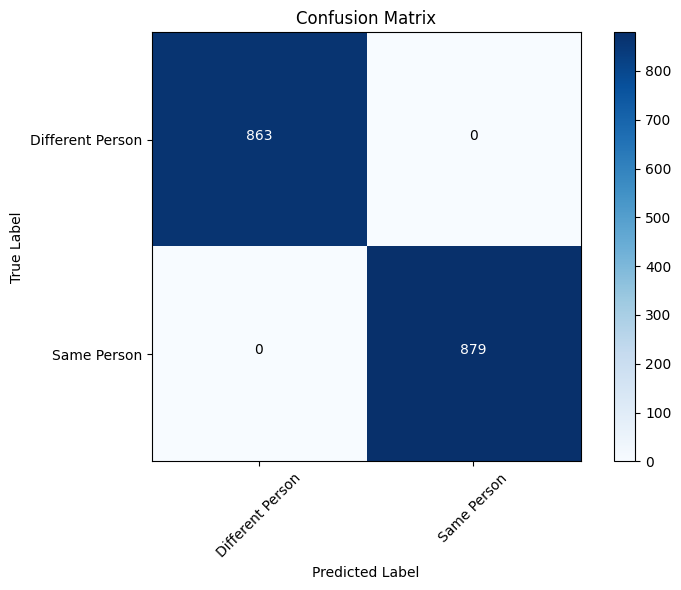

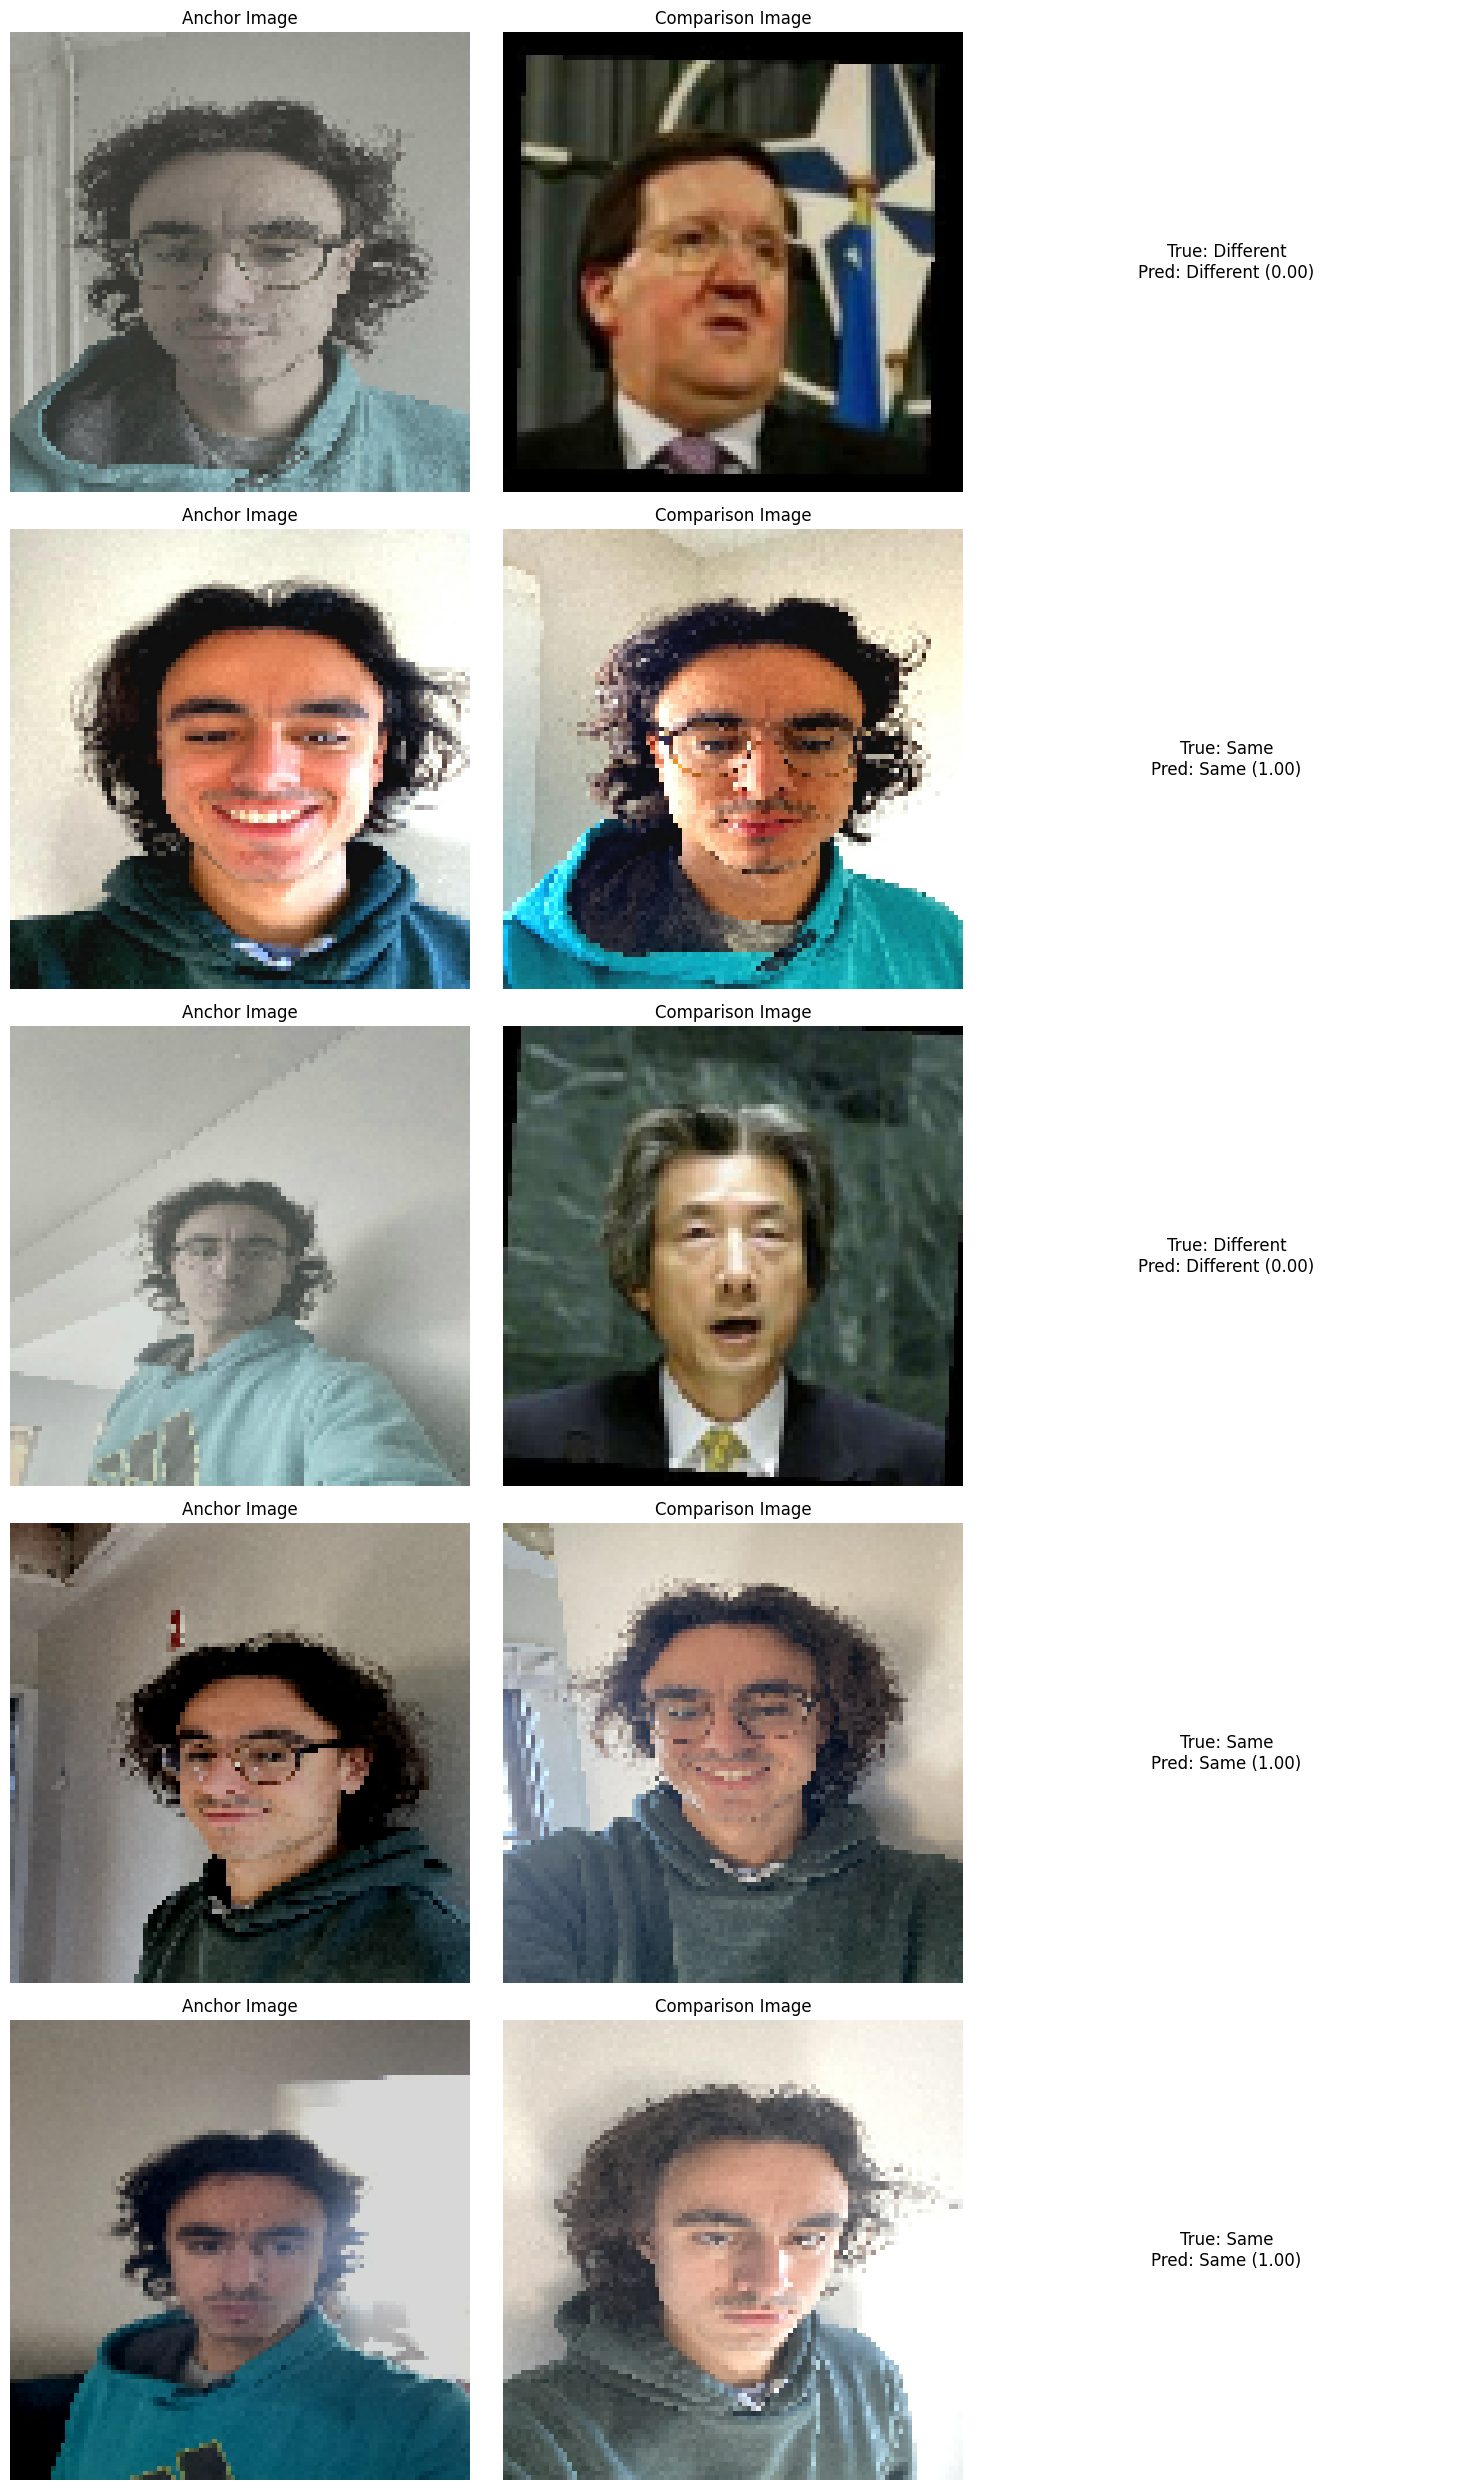

In [36]:

def evaluate_model(test_data):
    """
    Evaluate model performance on the test dataset
    Returns metrics and generates a confusion matrix
    """
    print("\nEvaluating model on test data...")

    # Lists to store predictions and true labels
    all_predictions = []
    all_labels = []

    # Loop through test batches to get predictions
    for batch in test_data:
        # Get anchor and comparison images
        anchor_img = batch[0]
        comparison_img = batch[1]
        # Get true labels
        labels = batch[2].numpy()

        # Get model predictions
        predictions = siamese_model.predict([anchor_img, comparison_img], verbose=0)
        # Convert probabilities to binary predictions (0 or 1)
        binary_predictions = (predictions > 0.5).astype(int).flatten()

        # Add batch results to our lists
        all_predictions.extend(binary_predictions)
        all_labels.extend(labels)

    # Convert to numpy arrays for easier manipulation
    all_predictions = np.array(all_predictions)
    all_labels = np.array(all_labels)

    # Calculate accuracy
    accuracy = np.mean(all_predictions == all_labels)
    print(f"Test Accuracy: {accuracy:.4f}")

    # Calculate precision, recall, and F1 score
    from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

    precision = precision_score(all_labels, all_predictions)
    recall = recall_score(all_labels, all_predictions)
    f1 = f1_score(all_labels, all_predictions)

    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    # Generate confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()

    classes = ['Different Person', 'Same Person']
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    # Add text annotations to confusion matrix
    thresh = cm.max() / 2
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                    horizontalalignment="center",
                    color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.savefig('confusion_matrix.png')
    plt.show()

    # Example predictions visualization
    def visualize_predictions(test_data, num_examples=5):
        """Visualize some example predictions"""
        plt.figure(figsize=(15, 5*num_examples))
        count = 0

        for batch in test_data:
            # Get a few examples
            for i in range(min(num_examples, len(batch[0]))):
                if count >= num_examples:
                    break

                # Get images and convert from tensor to numpy
                anchor_img = batch[0][i].numpy()
                comparison_img = batch[1][i].numpy()
                true_label = batch[2][i].numpy()

                # Get prediction
                pred = siamese_model.predict(
                    [tf.expand_dims(batch[0][i], 0), tf.expand_dims(batch[1][i], 0)],
                    verbose=0
                )[0][0]
                pred_label = 1 if pred > 0.5 else 0

                # Plot the pair and prediction
                plt.subplot(num_examples, 3, count*3 + 1)
                plt.imshow(anchor_img)
                plt.title("Anchor Image")
                plt.axis("off")

                plt.subplot(num_examples, 3, count*3 + 2)
                plt.imshow(comparison_img)
                plt.title("Comparison Image")
                plt.axis("off")

                plt.subplot(num_examples, 3, count*3 + 3)
                plt.text(0.5, 0.5,
                         f"True: {'Same' if true_label==1 else 'Different'}\n" +
                         f"Pred: {'Same' if pred_label==1 else 'Different'} ({pred:.2f})",
                         horizontalalignment='center',
                         verticalalignment='center',
                         fontsize=12,
                         transform=plt.gca().transAxes)
                plt.axis("off")

                count += 1

            if count >= num_examples:
                break

        plt.tight_layout()
        plt.savefig('example_predictions.png')
        plt.show()

    # Visualize some example predictions
    visualize_predictions(test_data)

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'confusion_matrix': cm
    }

# After training completes, evaluate the model
# Put this after your training code
test_metrics = evaluate_model(test_data)